# Glitching a simple double loop

In this notebook we target a dummy program (a double loop) using voltage glitching. The goal is to determine how suseptible our target is to voltage glitching. We also use this target to determine a range of glitch widths that result in faulty outputs. 

The following code snippet shows the code we are tying to glitch.

```C
void double_loop()
{
    char input;
    volatile int i, j, cnt;

    while (1)
    {
        UART_read(uart, &input, 1);
        if (input == 0xAA)
        {
            cnt = 0;
            GPIO_write(Board_GPIO_LED0, 1); // Set trigger high
            for (i = 0; i < 100; i++)
            {
                for (j = 0; j < 100; j++)
                {
                    cnt++;
                }
            }
            GPIO_write(Board_GPIO_LED0, 0); // Set trigger low
            UART_write(uart, &cnt, 4);
        }
    }
}
```

## Hardware Setup
To run this notebook you will need the hardware outlined in the main README of the repository. You will also need to modify your target for voltage glitching, at a minimum this requires removing C19 and connecting the ChipWhisperer glitch port to the DCOUPL pin. All instructions for modifying the targets are provided in the main README.

Make sure to connect your ChipWhisperer to the modified LAUNCHXL-CC2640R2 board before running the notebook.
* Connect the target SMA connector to your ChipWhisperer's Glitch/Crowbar port
* Remove the 3V3 jumper and connect the target side pin to the ChipWhisperer's 3V3 output
* Remove the RESET jumper and connect the target side to the ChipWhisperer's NRST output
* Connect the ChipWhisperer's IO4/TRG to the target's DIO6 pin
* Connect the ChipWhisperer's ground to a ground pin on the target board

## Preparation

The following cells load the required libraries and initialise the ChipWhisperer as well as our target.

In [1]:
import sys
import time
import os
import numpy as np
import chipwhisperer as cw
from tqdm.notebook import tqdm
import serial
import matplotlib.pyplot as plt

ser = 0

In [2]:
# Connect to the ChipWhisperer and perform some basic initialization

scope = cw.scope()

scope.clock.clkgen_src = 'system' 
scope.clock.clkgen_freq = 200e6          # Main ChipWhisperer clock
scope.clock.adc_mul = 0
scope.trigger.triggers = 'tio4'          # Trigger on a rising edge of TIO4 (connected to DIO6)
scope.adc.basic_mode = 'rising_edge'
scope.io.target_pwr = True

scope.glitch.enabled = True
scope.glitch.clk_src = 'pll'
#scope.clock.pll.update_fpga_vco(600e6)
scope.glitch.output = 'enable_only'
scope.glitch.trigger_src = 'ext_single'
scope.io.glitch_lp = True                # only using the 'low power' glitch mosfet
scope.io.glitch_hp = False
scope.glitch.repeat = 15                 # Glitch repeat (or glitch width) in cycles of the main CW clock.
scope.glitch.ext_offset = 300            # Glitch offset from the external trigger (in cycles of the main CW clock)

In [3]:
# Connect to the LAUNCHXL-CC2640R2 UART
# You may have to change the serial port ('/dev/ttyACM1')

if ser:
    ser.close()

ser = serial.Serial('/dev/ttyACM1', 115200)

In [4]:
# Modify the dslite_path variable to point to your installation of Uniflash
# Running this cell will load the example target firmware
# THIS WILL OVERWRITE THE FIRMWARE ON YOUR LAUNCHXL-CC2640R2

import subprocess
from pathlib import Path

home_dir = str(Path.home()) 
dslite_path = home_dir + '/ti/uniflash_7.0.0/dslite.sh'
erase_cmd = dslite_path + ' --mode cc13xx-cc26xx-mass-erase -d XDS110'
flash_cmd = dslite_path + ' --config ./bin/CC2640R2F.ccxml --flash ./bin/VFI_SCA_CC2640R2.out' 

process = subprocess.Popen(erase_cmd.split(' '), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output = process.communicate()

if b'Device Unlocked' not in output[0]:
    print('There was an error while trying to erase the microcontroller')
    print(output)
else:
    scope.io.nrst = 'low'
    scope.io.target_pwr = False
    time.sleep(0.1)
    scope.io.target_pwr = True
    scope.io.nrst = 'high'
    
    process = subprocess.Popen(flash_cmd.split(' '), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output = process.communicate()
    if b'Board Reset Complete' in output[0]:
        print('Target has been flashed!')
    else:
        print('Error flashing target. Check your connections and try again.')

Target has been flashed!


In [5]:
# Simple function to reset the target microcontroller
def reset_dut(delay=0.1):
    scope.io.nrst = 'low'
    scope.io.target_pwr = False
    time.sleep(delay)
    scope.io.target_pwr = True
    scope.io.nrst = 'high'
    time.sleep(0.05)
    ser.flushInput()
    ser.write(b'd') # To select the double loop function of the firmware
    

# A more thorough reset function that verifies that the target is alive again
def thorough_reset_dut(delay=0.05): 
    reset_dut(delay)
    
    ser.flushInput()
    ser.write(bytes([0xAA]))
    time.sleep(0.05)
    ret = ser.read(ser.in_waiting)
        
    while int.from_bytes(ret, 'little') != 10000:
        delay += 0.5
        reset_dut(delay)
        ser.write(bytes([0xAA]))
        time.sleep(0.05)
        ret = ser.read(ser.in_waiting)

In [6]:
# Make sure the target is performing the double loop function

reset_dut(1)
ser.write(bytes([0xAA]))
time.sleep(0.05)
ret = ser.read(ser.in_waiting)
cnt = int.from_bytes(ret, 'little')

if cnt != 10000:
    print('The output received from the target is not correct..')
    print(ret, cnt)
else:
    print('All set to start glitching!')

All set to start glitching!


## A basic glitching experiment

The following cell uses a fixed glitch width (`scope.glitch.repeat`) and iterates over a range of offsets starting from the trigger signal. At each offset we try to inject 5 glitches.

We assume the target crashed if it does not return any output. We successfully injected a glitch if the target replies with a counter value that is not equal to 10000, those values will be printed. In both cases we reset the target device.

This cell should take roughly 50 seconds to complete and should produce at least a few faulty counter outputs!
Feel free to play around with the parameters (`scope.glitch.repeat`, `offsets`, `repeats`).
If you are not getting any faulted outputs and 0% crashes you might want to try and increase the `scope.glitch.repeat` value. Similarly, if you get 100% crashes you can try lowering this value.

In [7]:
scope.glitch.repeat = 15
offsets = np.arange(0, 2000, 20)
repeats = 5

crashes = 0
faults = 0

for offset in tqdm(range(len(offsets))):
    scope.glitch.ext_offset = offsets[offset]
    
    for i in range(repeats):
        scope.arm()
        ser.write(bytes([0xAA]))
        time.sleep(0.05)
        ret = ser.read(ser.in_waiting)
        
        if ret != b"\x10'\x00\x00":
            if ret == b'':
                crashes += 1
            else:
                faults += 1
                print('Fault?!', int.from_bytes(ret, 'little'), ret.hex())
            thorough_reset_dut() 
                
total = len(offsets)*repeats
print("\nTotal # attempts:", total) 
print("Total # faults: %d (%f%%)" % (faults, (faults/total)*100))
print("Total # crashes: %d (%f%%)" % (crashes, (crashes/total)*100))

  0%|          | 0/100 [00:00<?, ?it/s]

Fault?! 10001 11270000
Fault?! 10002 12270000
Fault?! 10002 12270000
Fault?! 9899 ab260000
Fault?! 9999 0f270000
Fault?! 10001 11270000
Fault?! 9911 b7260000
Fault?! 8899 c3220000
Fault?! 9999 0f270000
Fault?! 9999 0f270000
Fault?! 9911 b7260000
Fault?! 9901 ad260000
Fault?! 9999 0f270000
Fault?! 9914 ba260000
Fault?! 9915 bb260000
Fault?! 10001 11270000
Fault?! 9885 9d260000
Fault?! 30231 17760000
Fault?! 9918 be260000
Fault?! 10001 11270000
Fault?! 10018 22270000
Fault?! 10018 22270000
Fault?! 8318 7e200000
Fault?! 10063 4f270000
Fault?! 9909 b5260000
Fault?! 9921 c1260000
Fault?! 9921 c1260000
Fault?! 9924 c4260000
Fault?! 7599 af1d0000
Fault?! 9924 c4260000
Fault?! 9926 c6260000
Fault?! 10027 2b270000
Fault?! 9927 c7260000
Fault?! 10001 11270000

Total # attempts: 500
Total # faults: 34 (6.800000%)
Total # crashes: 92 (18.400000%)


## Determining a good glitch width

The following cells perform a similar experiment to the previous one, but in this case we also iterate over multiple glitch widths and keep track of the number of faults and crashes per combination of glitch offset and glitch width. This allows to create a visual map (similar to Figure 3 in the paper).

In [8]:
offsets = np.arange(0, 100, 4)
widths = np.arange(10, 28, 1)
repeats = 10

#offsets = np.arange(0, 400, 4)
#widths = np.arange(10, 28, 1)
#repeats = 50

crashes = np.zeros((len(offsets), len(widths)))
faults = np.zeros((len(offsets), len(widths)))

In [11]:
for offset in tqdm(range(len(offsets))):
    for width in range(len(widths)):
        scope.glitch.ext_offset = offsets[offset]
        scope.glitch.repeat = widths[width]
    
        for i in range(repeats):
            scope.arm()
            ser.write(bytes([0xAA]))
            time.sleep(0.05)
            ret = ser.read(ser.in_waiting)
            if ret != b"\x10'\x00\x00":
                if ret == b'':
                    crashes[offset, width] += 1
                    thorough_reset_dut()
                else:
                    faults[offset, width] += 1
                    print(int.from_bytes(ret, 'little'), ret.hex())

                thorough_reset_dut()
                    
                    
    print('Offset: %d, faults: %d, crashes: %d' % (offsets[offset], np.sum(faults[offset,:]), np.sum(crashes[offset,:])))
    
print('The glitch width resuling in most fauly counter outputs is:', widths[np.argmax(np.sum(faults, axis=0))])

  0%|          | 0/25 [00:00<?, ?it/s]

1585152 003018
Offset: 0, faults: 1, crashes: 119
1581056 002018
Offset: 4, faults: 1, crashes: 111
532480 002008
1585152 003018
Offset: 8, faults: 2, crashes: 122
Offset: 12, faults: 0, crashes: 109
Offset: 16, faults: 0, crashes: 107
Offset: 20, faults: 0, crashes: 105
1585152 003018
532480 002008
1585152 003018
536576 003008
532480 002008
Offset: 24, faults: 5, crashes: 105
1585152 003018
1585152 003018
532480 002008
Offset: 28, faults: 3, crashes: 110
Offset: 32, faults: 0, crashes: 121
9900 ac260000
9900 ac260000
1581056 002018
Offset: 36, faults: 3, crashes: 98
1342191276 ac360050
1342191376 10370050
9900 ac260000
1342191376 10370050
9900 ac260000
532480 002008
Offset: 40, faults: 6, crashes: 92
9900 ac260000
0 00000000
9900 ac260000
9900 ac260000
0 00000000
9900 ac260000
9900 ac260000
9900 ac260000
9999 0f270000
0 00000000
0 00000000
0 00000000
0 00000000
9900 ac260000
9900 ac260000
Offset: 44, faults: 15, crashes: 88
0 00000000
9901 ad260000
9901 ad260000
9900 ac260000
9900 ac2

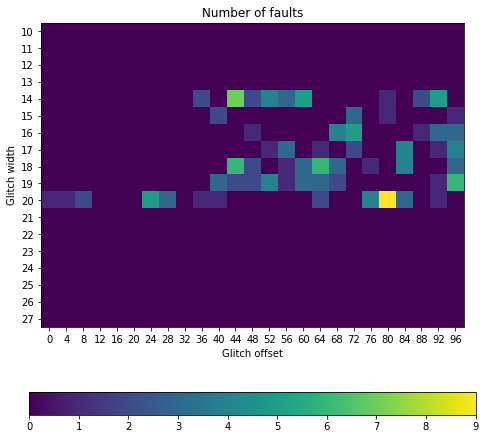

In [12]:
fig = plt.figure(figsize=(8, 8))
plt.title('Number of faults')
plt.xlabel('Glitch offset')
plt.ylabel('Glitch width')
plt.imshow(faults.T, interpolation='none')
plt.xticks(range(0,len(offsets)), offsets)
plt.yticks(range(0,len(widths)), widths)
plt.colorbar(orientation='horizontal')
plt.show()

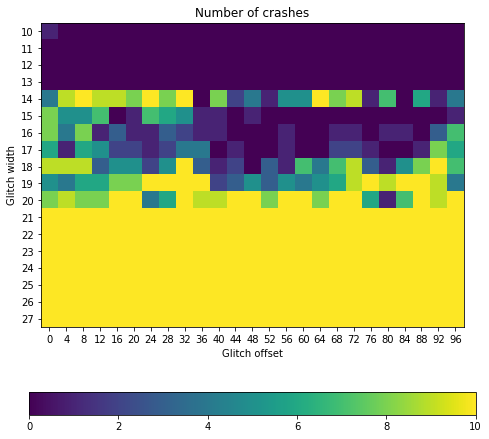

In [14]:
fig = plt.figure(figsize=(8, 8))
plt.title('Number of crashes')
plt.xlabel('Glitch offset')
plt.ylabel('Glitch width')
plt.imshow(crashes.T, interpolation='none')
plt.xticks(range(0,len(offsets)), offsets)
plt.yticks(range(0,len(widths)), widths)
plt.colorbar(orientation='horizontal')
plt.show()

In [15]:
ser.close()
scope.dis()

True